In [73]:
!python --version

Python 3.9.12


In [74]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [75]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [77]:
np.random.seed(42)

In [78]:
df = pd.read_csv('Customer_Churn_Prediction.csv')

In [79]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [81]:
#check if every row is unique to one customer
df["phone number"].nunique()

3333

In [82]:
area_code_dummies = pd.get_dummies(df["area code"])
area_code_dummies = area_code_dummies.add_prefix('area_code_')
area_code_dummies

,area_code_408,area_code_415,area_code_510
0,0,1,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0
...,...,...,...
3328,0,1,0
3329,0,1,0
3330,0,0,1
3331,0,0,1


In [83]:
df["voice mail plan"] = df["voice mail plan"].replace({"no":0,"yes":1})
df["voice mail plan"] = df["voice mail plan"].astype(int)

In [84]:
df["international plan"] = df["international plan"].replace({"no":0,"yes":1})
df["international plan"] = df["international plan"].astype(int)

In [85]:
# form final dataset
#drop also state to avoid high dimensionality issues
df_final = df.drop(columns = ["phone number", "state", "area code"])
df_final = pd.concat([df_final,area_code_dummies], axis = 1)
df_final

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,area_code_408,area_code_415,area_code_510
0,128,0,1,25,265.1,110,45.07,197.4,99,16.78,...,91,11.01,10.0,3,2.70,1,False,0,1,0
1,107,0,1,26,161.6,123,27.47,195.5,103,16.62,...,103,11.45,13.7,3,3.70,1,False,0,1,0
2,137,0,0,0,243.4,114,41.38,121.2,110,10.30,...,104,7.32,12.2,5,3.29,0,False,0,1,0
3,84,1,0,0,299.4,71,50.90,61.9,88,5.26,...,89,8.86,6.6,7,1.78,2,False,1,0,0
4,75,1,0,0,166.7,113,28.34,148.3,122,12.61,...,121,8.41,10.1,3,2.73,3,False,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,0,1,36,156.2,77,26.55,215.5,126,18.32,...,83,12.56,9.9,6,2.67,2,False,0,1,0
3329,68,0,0,0,231.1,57,39.29,153.4,55,13.04,...,123,8.61,9.6,4,2.59,3,False,0,1,0
3330,28,0,0,0,180.8,109,30.74,288.8,58,24.55,...,91,8.64,14.1,6,3.81,2,False,0,0,1
3331,184,1,0,0,213.8,105,36.35,159.6,84,13.57,...,137,6.26,5.0,10,1.35,2,False,0,0,1


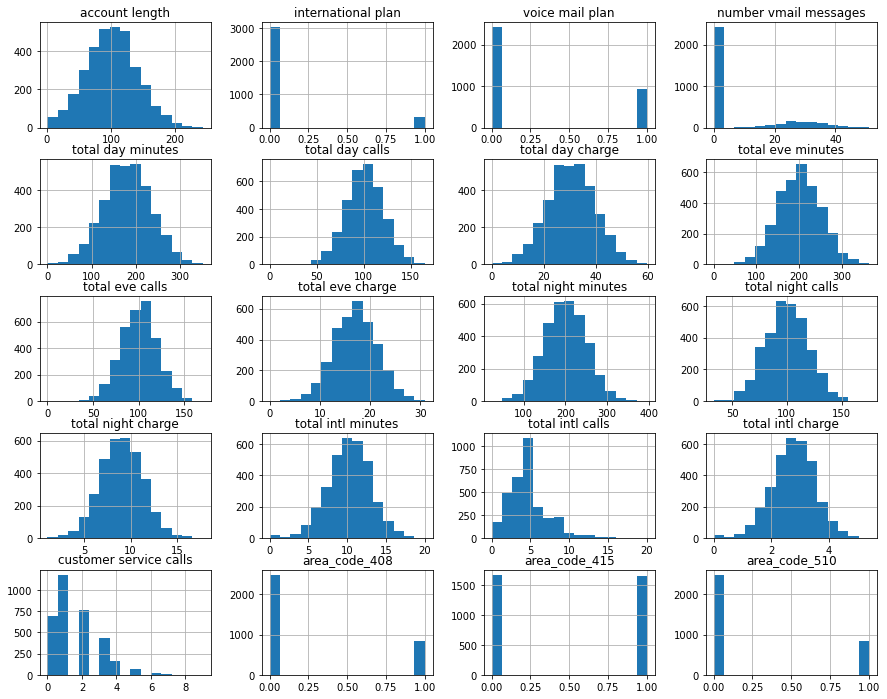

In [86]:
df_final.hist(figsize=(15,12),bins =15)
plt.show()

In [87]:
# check classes ratio
df_final.groupby(['churn'])['churn'].count()

churn
False    2850
True      483
Name: churn, dtype: int64

<AxesSubplot:>

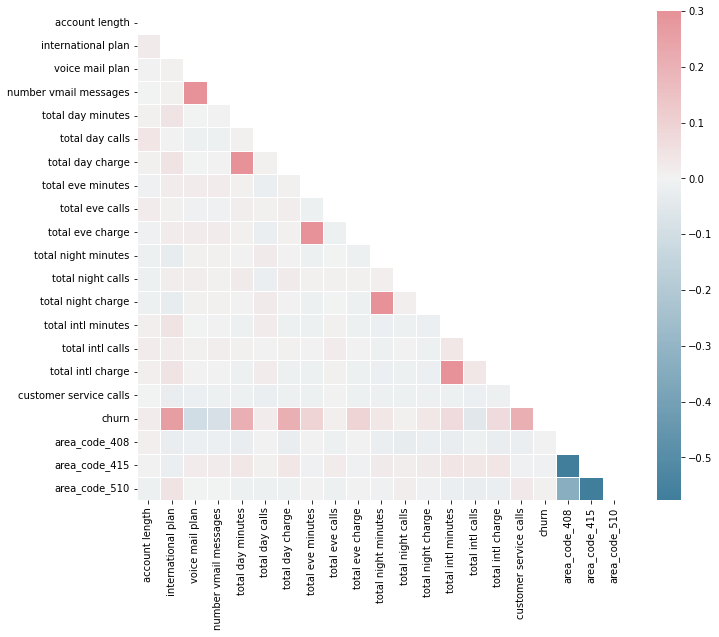

In [88]:
# some insights into the relationship between features
corr = df_final.corr()
# to have a better visualization, better to take only one triangle 
# because other trangle is only its symmetry
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize = (11,9))
cmap = sns.diverging_palette(h_pos = 10,h_neg = 230, as_cmap = True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = False,
            square=True, linewidths= 1)

In [89]:
"""check feature importances via random forest classifier"""
le = preprocessing.LabelEncoder()
y = le.fit_transform(df_final["churn"])
X = df_final.drop(columns = ["churn"])

In [90]:
X = StandardScaler().fit_transform(X)
X

array([[ 0.67648946, -0.32758048,  1.6170861 , ..., -0.57954443,
         1.00692466, -0.5804683 ],
       [ 0.14906505, -0.32758048,  1.6170861 , ..., -0.57954443,
         1.00692466, -0.5804683 ],
       [ 0.9025285 , -0.32758048, -0.61839626, ..., -0.57954443,
         1.00692466, -0.5804683 ],
       ...,
       [-1.83505538, -0.32758048, -0.61839626, ..., -0.57954443,
        -0.99312296,  1.72274698],
       [ 2.08295458,  3.05268496, -0.61839626, ..., -0.57954443,
        -0.99312296,  1.72274698],
       [-0.67974475, -0.32758048,  1.6170861 , ..., -0.57954443,
         1.00692466, -0.5804683 ]])

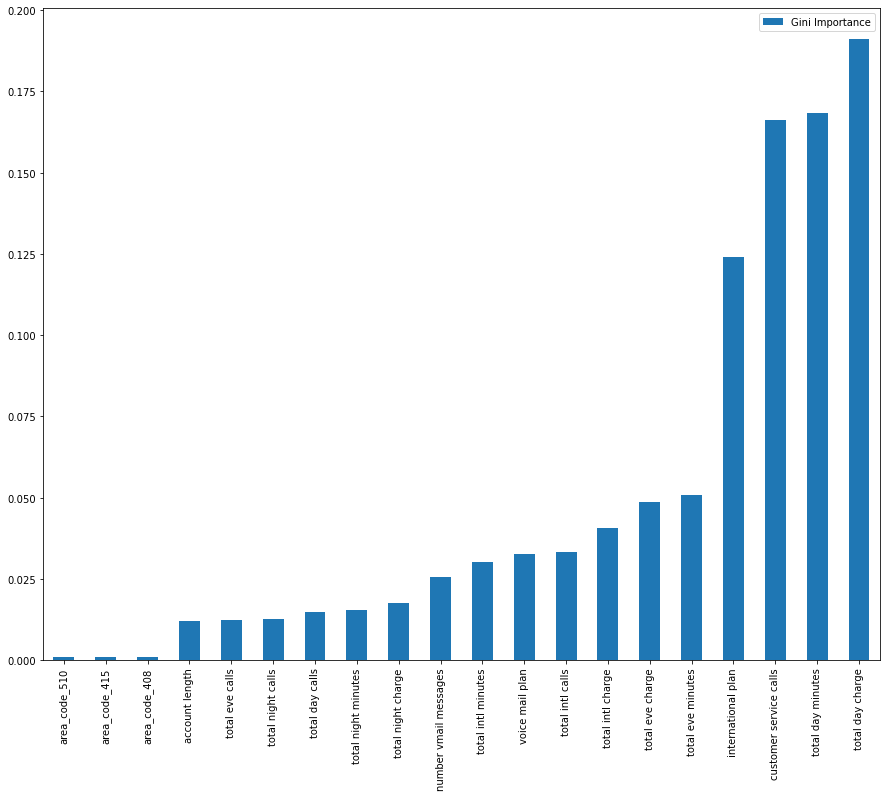

In [91]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2,random_state = 42)
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestClassifier(max_depth = 5)
forest.fit(X_train,y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature,importance in zip(df_final.drop(columns=["churn"]).columns,forest.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient = 'index').rename(columns={0:'Gini Importance'})
importances.sort_values(by ='Gini Importance' ).plot(kind = "bar", rot = 90, figsize = (15,12))
plt.show()

In [92]:
###2. Train/Test Split
le = preprocessing.LabelEncoder()
y = le.fit_transform(df_final["churn"])

In [93]:
X = df_final.drop(columns=["churn"]) 

In [94]:
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
# Apply classifiers and decide to pick one to use in production based on the performance
# Hyperparameters of the given classifiers are chosen as trial-error 
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "XGBoost",
    "LightGBM"
]


classifiers = [

    KNeighborsClassifier(3), 
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, random_state=42),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=0),
    LGBMClassifier(random_state=42),
]

In [100]:
for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        cv_scores = cross_val_score(clf,X_train, y_train,cv =3, scoring = "accuracy")
        y_train_pred = cross_val_predict(clf,X_train, y_train,cv =3)
        cm = confusion_matrix(y_train, y_train_pred)
        print(f"{clf}                                                                                                " , cm)


KNeighborsClassifier(n_neighbors=3)                                                                                                 [[2224   60]
 [ 279  103]]
SVC(C=0.025, kernel='linear')                                                                                                 [[2284    0]
 [ 382    0]]
SVC(C=1, gamma=2)                                                                                                 [[2284    0]
 [ 382    0]]
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1), random_state=42)                                                                                                 [[2243   41]
 [ 200  182]]
DecisionTreeClassifier(max_depth=5, random_state=42)                                                                                                 [[2256   28]
 [ 125  257]]
RandomForestClassifier(max_depth=5, random_state=42)                                                                                                 [[2278    6]
 [ 250  

C:\Users\khalilli.k\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\khalilli.k\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\khalilli.k\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\khalilli.k\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\khalilli.k\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\khalilli.k\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\U

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)                                                                                                 [[2257   27]
 [ 107  275]]
[LightGBM] [Info] Number of positive: 382, number of negative: 2284
[LightGBM] [Info] Auto-choosing col-wise mult